# Experiment Tracking with MLFlow (Local)

In this demo we will see how to use MLFlow for tracking experiments, using a toy data set. In the attached lab (below), you will download a larger dataset and attempt to train the best model that you can.

We should first install mlflow, and add it to the requirements.txt file if not done already.

`pip install mlflow` or `python3 -m pip install mlflow`.

You may also need to `pip install setuptools`.

From here, make sure to save this notebook in a specific folder, and ensure you run all command line commands from the same folder.

In [54]:
import mlflow
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_wine
from sklearn.metrics import accuracy_score

After loading the libraries, we can first check the mlflow version you have. And, just for fun, let's look at the mlflow UI by running `mlflow ui`. After this, we should do two things:
- set the tracking uri
- create or set the experiment

Setting the tracking uri tells mlflow where to save the results of our experiments. We will first save these locally in a sqlite instance. In a future lab we will set up mlflow to run in GCP.

If you've already created an experiment previously that you'd like to use, you can tell mlflow by setting the experiment. You can also use `set_experiment` even if the experiment has not yet been created - mlflow will first check if the experiment exists, and if not, it will create it for you. 

In [55]:
mlflow.__version__

'2.15.1'

Running the below code will create a sqlite database and an mlruns folder in the current directory.

In [56]:
mlflow.set_tracking_uri('sqlite:///mlflow.db')
mlflow.set_experiment('demo-experiment-4')

<Experiment: artifact_location='/Users/quinnc/Desktop/msds603/mlops/Labs/mlruns/3', creation_time=1742685199026, experiment_id='3', last_update_time=1742685199026, lifecycle_stage='active', name='demo-experiment-4', tags={}>

From here, we can load the wine data from sklearn and take a look at it. Then let's play around with some models, without using mlflow for now, to get a sense of why mlflow might come in handy.

In [57]:
wine = load_wine()
df_wine = pd.DataFrame(data=wine.data, columns=wine.feature_names)
df_wine.head(3)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0


In [58]:
y = wine.target
X = df_wine
dt = DecisionTreeClassifier(max_depth=4)
dt.fit(X, y)

DecisionTreeClassifier(max_depth=4)

In [59]:
accuracy_score(y, dt.predict(df_wine))

0.9887640449438202

## Train a Model Using MLFLow

In this section, let's train a simple decision tree model, where we will now adjust the maximum depth (`max_depth`) of the tree, and save the results of each run of the experiment using mlflow. To do so, we need to tell mlflow to start recording. We do this with `start_run`. 

The things we might want to record in this simple case are:
- the value of `max_depth`
- the corresponding accuracy of the model

We can also tag each run to make it easier to identify them later.

After running the below code, be sure to check the mlflow UI by running the following in the terminal from the same directory as where you saved this notebook:

`mlflow ui` note that just running this you will not see any of your experiments. You must specify the uri (the place where all of your results are being stored)

`mlflow ui --backend-store-uri sqlite:///mlflow.db`

In [60]:
with mlflow.start_run():
    # log parameters and log metrics
    # parameters: hyperparameters
    # metrics: model performance metrics

    mlflow.set_tags({"Model":"decision-tree", "Train Data": "all-data"})

    tree_depth = 5
    dt = DecisionTreeClassifier(max_depth=tree_depth)
    dt.fit(X, y)
    acc = accuracy_score(y, dt.predict(df_wine))

    mlflow.log_param("max_depth", tree_depth)
    mlflow.log_metric("accuracy", acc)

mlflow.end_run()

Let's do it again, but this time we'll use a random forest, which has some other hyperparameters we can tune, which makes keeping track of things a little more complex without a tool like mlflow.

In [61]:
from sklearn.ensemble import RandomForestClassifier

with mlflow.start_run():
    mlflow.set_tags({"Model":"random-forest", "Train Data": "all-data"})

    ntree = 1000
    mtry = 4

    mlflow.log_params({'n_estimators':ntree, 'max_features':mtry})

    rf = RandomForestClassifier(n_estimators = ntree, max_features = mtry, oob_score = True)
    rf.fit(X,y)
    acc = rf.oob_score_
    #acc = accuracy_score(y, rf.predict(X))
    mlflow.log_metric('accuracy', acc)

mlflow.end_run()

Typically, in a real-world scenario, you wouldn't change your parameter values manually and re-run your code, you would either use a loop to loop through different parameter values, or you'd use a built-in method for doing cross-validation, of which there are a few. First, let's use a simple loop to run the experiment multiple times, and save the results of each run.

In [62]:
ntrees = [20,40,60,80,100]
mtrys = [3,4,5]
for i in ntrees:
    for j in mtrys:
        with mlflow.start_run():
            mlflow.set_tags({"Model":"random-forest", "Train Data": "all-data"})

            mlflow.log_params({'n_estimators':i, 'max_features':j})

            rf = RandomForestClassifier(n_estimators = i, max_features = j, oob_score = True)
            rf.fit(X,y)
            acc = rf.oob_score_
            #acc = accuracy_score(y, rf.predict(X))
            mlflow.log_metric('accuracy', acc)
        mlflow.end_run()

## Training a Model with mlflow and hyperopt

One way of tuning your model is to use the `hyperopt` library. `hyperopt` is a library that does hyperparameter tuning, and does so in a way that makes it easy for mlflow to keep track of the results. 

First, install the libraries you don't have, and then load them below. We do not use `hyperopt` much in the class, so if you don't want to add it to your requirements.txt file, you don't have to.

For this exercise, we'll split the data into training and validation, and then we'll train decision trees and random forests and use `hyperopt` to do the hyperparameter tuning and find the best model for us.

In [63]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

From the above we will use `cross_val_score` for our metric, `fmin` is used by `hyperopt` to do the tuning, `tpe` (Tree of Parzen Estimators) is the algorithm used to search the hyperparameter space,  `hp` has methods we need to use for defining our search space, `STATUS_OK` is a status message that each run completed, and `Trials` keeps track of each run.

In [64]:
def objective(params):
    with mlflow.start_run():
        classifier_type = params['type']
        del params['type']
        if classifier_type == 'dt':
            clf = DecisionTreeClassifier(**params)
        elif classifier_type == 'rf':
            clf = RandomForestClassifier(**params)        
        else:
            return 0
        acc = cross_val_score(clf, X, y).mean()

        mlflow.set_tag("Model", classifier_type)
        mlflow.log_params(params)
        mlflow.log_metric("accuracy", acc)
        mlflow.end_run()
        return {'loss': -acc, 'status': STATUS_OK}

search_space = hp.choice('classifier_type', [
    {
        'type': 'dt',
        'criterion': hp.choice('dtree_criterion', ['gini', 'entropy']),
        'max_depth': hp.choice('dtree_max_depth', [None, hp.randint('dtree_max_depth_int', 1,10)]),
        'min_samples_split': hp.randint('dtree_min_samples_split', 2,10)
    },
    {
        'type': 'rf',
        'n_estimators': hp.randint('rf_n_estimators', 20, 500),
        'max_features': hp.randint('rf_max_features', 2,9),
        'criterion': hp.choice('criterion', ['gini', 'entropy'])
    },
])

algo = tpe.suggest
trials = Trials()

In [65]:
best_result = fmin(
        fn=objective, 
        space=search_space,
        algo=algo,
        max_evals=32,
        trials=trials)

100%|██████████| 32/32 [00:16<00:00,  1.94trial/s, best loss: -0.9833333333333332]


In [66]:
best_result

{'classifier_type': 1,
 'criterion': 1,
 'rf_max_features': 2,
 'rf_n_estimators': 386}

### Using Autologging

Rather than manually logging parameters and metrics, mlflow has an autolog feature, which is compatible with a subset of python libraries, such as sklearn. Autologging makes it easy to log all of the important stuff, without having to manually write lines of code to log the parameters. However, sometimes you will want to have finer control over what gets logged, and should instead skip autologging.

In [67]:

with mlflow.start_run():
    mlflow.sklearn.autolog()
    tree_depth = 5
    dt = DecisionTreeClassifier(max_depth=tree_depth)
    dt.fit(X_train, y_train)
    mlflow.sklearn.autolog(disable=True)
mlflow.end_run()

# Artifact Tracking and Model Registry (Local)

In this section we will save some artifacts from our model as we go through the model development process. There are a few things that might be worth saving, such as datasets, plots, and the final model itself that might go into production later.

## Data

First, let's see how we can store our important datasets, in a compressed format, for use for later, for example, in case we get a new request about our model and need to run some analyses (such as "what is the distribution of this feature, but only for this specific subset of data?" or "how did the model do on these particular observations from your validation set?").

In [68]:
import os 

os.makedirs('save_data', exist_ok = True)

X_train.to_parquet('save_data/x_train.parquet')

mlflow.log_artifact('save_data/x_train.parquet')

In [69]:
X_test.to_parquet('save_data/x_test.parquet')

mlflow.log_artifacts('save_data/')

You can now go to the mlflow UI, click on the latest run, and select the Artifacts tab. You should see something similar to this:
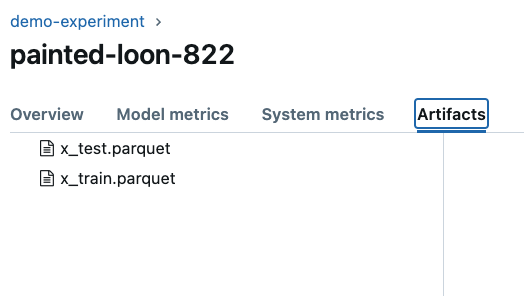

## Images

As part of the model dev process you may end up creating visualizations that can be useful for analysis, or for reporting. You can use mlflow to log the important ones and ignore the rest. After creating the below figure, save into a folder called images, and then you can log whatever is in the `images` folder as an artifact.

array([[<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>, <Axes: ylabel='Density'>],
       [<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>, <Axes: ylabel='Density'>],
       [<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>, <Axes: ylabel='Density'>],
       [<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>, <Axes: ylabel='Density'>]], dtype=object)

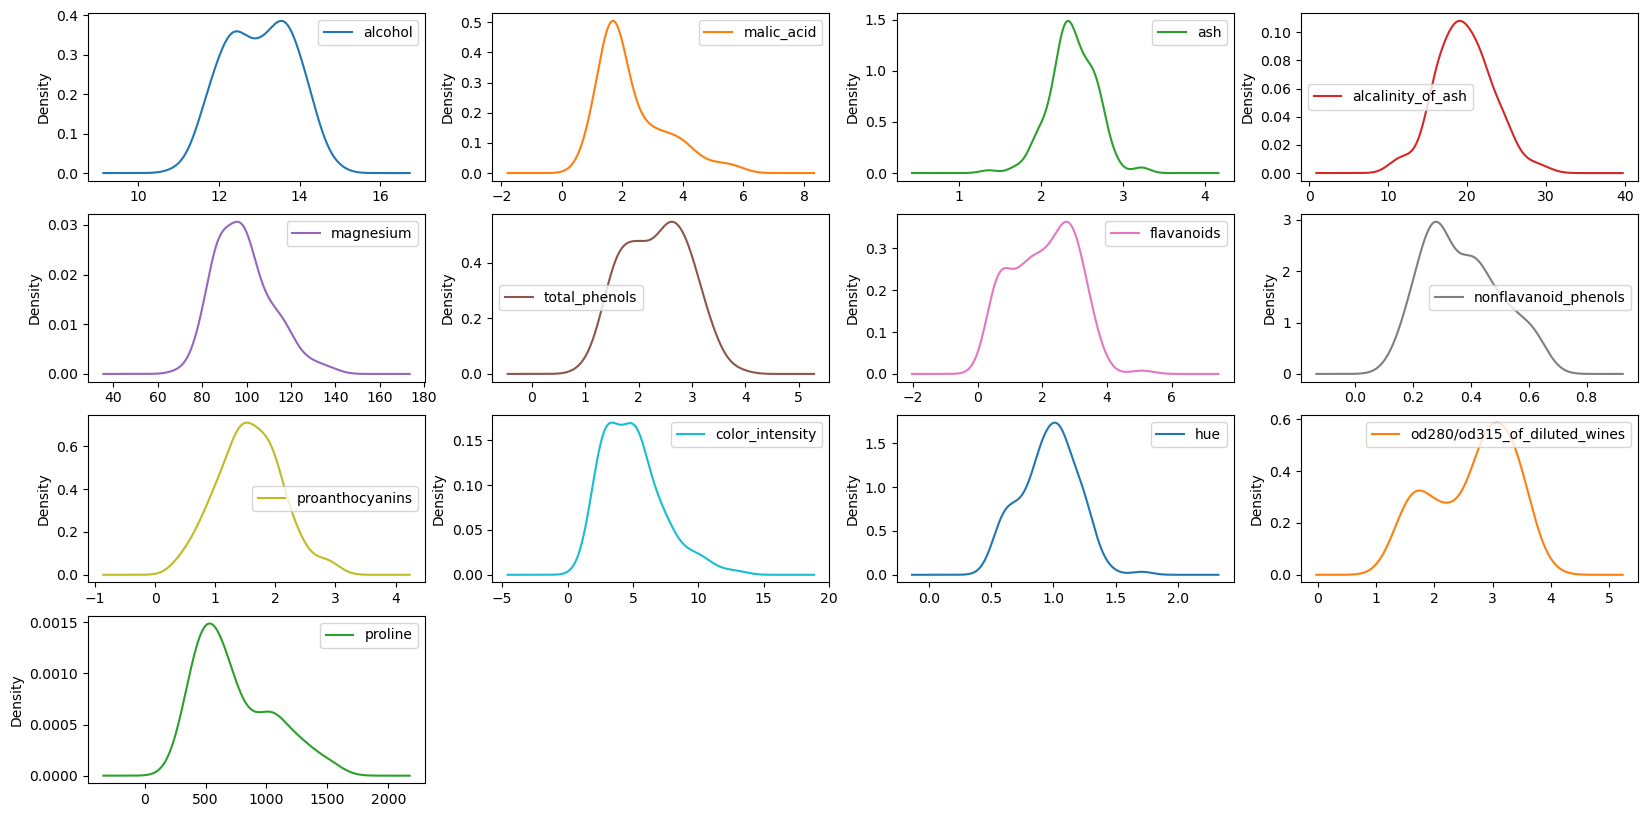

In [70]:
%matplotlib inline
os.makedirs('images', exist_ok = True)
X_train.plot.density(subplots = True, figsize = (20,10), layout = (4,4), sharey = False, sharex = False)

In [71]:
mlflow.log_artifacts('images')
mlflow.end_run()

Notice how all of the artifacts were saved in the same run of the experiment. We could have added an `mlflow.end_run()` in between our `log_artifacts` lines to separate runs if we wanted to.

## Model Management and Model Registry

As you are developing your models you may want to save certain versions of the model, or maybe even all of them, so that you don't have to go back and retrain them later. We can do this in mlflow by logging the models, not as artifacts, but as models, using `log_model`. 

In this section we'll log a couple of models to see how mlflow handles model management. Above, we used `hyperopt` to train a bunch of models at once. Let's do this again, and log some of the models that we train.

### Logging as an Artifact

First we can try logging a model as an artifact. To do this, we must first save the model itself, which we can do by using the `pickle` library. We then log the model as an artifact like we did with data and images. 

In [72]:
import pickle

os.makedirs('../models', exist_ok = True)

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

with open('../models/model.pkl','wb') as f:
    pickle.dump(dt,f)

# First we'll log the model as an artifact
mlflow.log_artifact('../models/model.pkl', artifact_path='my_models')

### Logging as a Model

Logging the model as an artifact only logs the pickle file (the serialized version of the model). It's not really very useful, especially since models contain so much metadata that might be critical to know for deploying the model later. mlflow has a built-in way of logging models specifically, so let's see how to use this, and how it's different from logging models as an artifact.

In [73]:
# Let's do it again, but this time we will log the model using log_model
mlflow.sklearn.log_model(dt, artifact_path = 'better_models')
mlflow.end_run()

2025/03/23 22:31:33 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Ok, so if you go to the mlflow UI at this point you can see the difference in `log_artifact`, which simply logs the pickle file, and `log_model`, which also gives you information about the environment, required packages, and model flavor.

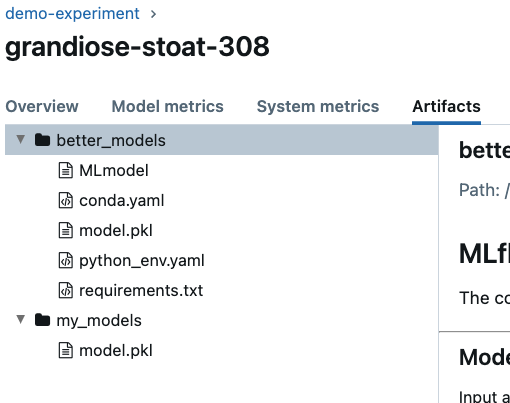

Let's do this one more time, but this time let's use `hyperopt` and log all of the trained models separately. Let's do this in a new experiment called 'demo-experiment2'. 

In [74]:
mlflow.set_experiment('demo-experiment5')
def objective(params):
    with mlflow.start_run():
        classifier_type = params['type']
        del params['type']
        if classifier_type == 'dt':
            clf = DecisionTreeClassifier(**params)
        elif classifier_type == 'rf':
            clf = RandomForestClassifier(**params)        
        else:
            return 0
        acc = cross_val_score(clf, X, y).mean()

        mlflow.set_tag("Model", classifier_type)
        mlflow.log_params(params)
        mlflow.log_metric("accuracy", acc)
        mlflow.sklearn.log_model(clf, artifact_path = 'better_models')
        mlflow.end_run()
        return {'loss': -acc, 'status': STATUS_OK}
search_space = hp.choice('classifier_type', [
    {
        'type': 'dt',
        'criterion': hp.choice('dtree_criterion', ['gini', 'entropy']),
        'max_depth': hp.choice('dtree_max_depth', [None, hp.randint('dtree_max_depth_int', 1,10)]),
        'min_samples_split': hp.randint('dtree_min_samples_split', 2,10)
    },
    {
        'type': 'rf',
        'n_estimators': hp.randint('rf_n_estimators', 20, 500),
        'max_features': hp.randint('rf_max_features', 2,9),
        'criterion': hp.choice('criterion', ['gini', 'entropy'])
    },
])

algo = tpe.suggest
trials = Trials()
best_result = fmin(
        fn=objective, 
        space=search_space,
        algo=algo,
        max_evals=32,
        trials=trials)

  0%|          | 0/32 [00:00<?, ?trial/s, best loss=?]

2025/03/23 22:31:34 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



  3%|▎         | 1/32 [00:01<00:32,  1.06s/trial, best loss: -0.8931746031746032]

2025/03/23 22:31:35 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



  6%|▋         | 2/32 [00:02<00:31,  1.05s/trial, best loss: -0.8931746031746032]

2025/03/23 22:31:37 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



  9%|▉         | 3/32 [00:03<00:37,  1.31s/trial, best loss: -0.9665079365079364]

2025/03/23 22:31:39 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 12%|█▎        | 4/32 [00:05<00:39,  1.42s/trial, best loss: -0.9665079365079364]

2025/03/23 22:31:40 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 16%|█▌        | 5/32 [00:06<00:34,  1.29s/trial, best loss: -0.9665079365079364]

2025/03/23 22:31:41 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 19%|█▉        | 6/32 [00:07<00:31,  1.23s/trial, best loss: -0.9665079365079364]

2025/03/23 22:31:42 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 22%|██▏       | 7/32 [00:09<00:33,  1.34s/trial, best loss: -0.9665079365079364]

2025/03/23 22:31:44 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 25%|██▌       | 8/32 [00:10<00:35,  1.49s/trial, best loss: -0.9777777777777779]

2025/03/23 22:31:46 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 28%|██▊       | 9/32 [00:13<00:39,  1.70s/trial, best loss: -0.9777777777777779]

2025/03/23 22:31:47 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 31%|███▏      | 10/32 [00:14<00:32,  1.49s/trial, best loss: -0.9777777777777779]

2025/03/23 22:31:48 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 34%|███▍      | 11/32 [00:15<00:28,  1.35s/trial, best loss: -0.9777777777777779]

2025/03/23 22:31:49 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 38%|███▊      | 12/32 [00:16<00:25,  1.25s/trial, best loss: -0.9777777777777779]

2025/03/23 22:31:51 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 41%|████      | 13/32 [00:17<00:22,  1.20s/trial, best loss: -0.9777777777777779]

2025/03/23 22:31:52 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 44%|████▍     | 14/32 [00:18<00:20,  1.16s/trial, best loss: -0.9777777777777779]

2025/03/23 22:31:53 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 47%|████▋     | 15/32 [00:19<00:19,  1.13s/trial, best loss: -0.9777777777777779]

2025/03/23 22:31:55 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 50%|█████     | 16/32 [00:21<00:21,  1.34s/trial, best loss: -0.9777777777777779]

2025/03/23 22:31:56 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 53%|█████▎    | 17/32 [00:22<00:18,  1.25s/trial, best loss: -0.9777777777777779]

2025/03/23 22:31:57 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 56%|█████▋    | 18/32 [00:23<00:16,  1.18s/trial, best loss: -0.9777777777777779]

2025/03/23 22:31:58 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 59%|█████▉    | 19/32 [00:24<00:14,  1.13s/trial, best loss: -0.9777777777777779]

2025/03/23 22:31:59 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 62%|██████▎   | 20/32 [00:25<00:13,  1.10s/trial, best loss: -0.9777777777777779]

2025/03/23 22:32:01 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 66%|██████▌   | 21/32 [00:27<00:15,  1.41s/trial, best loss: -0.9777777777777779]

2025/03/23 22:32:02 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 69%|██████▉   | 22/32 [00:28<00:13,  1.36s/trial, best loss: -0.9777777777777779]

2025/03/23 22:32:04 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 72%|███████▏  | 23/32 [00:30<00:14,  1.65s/trial, best loss: -0.9777777777777779]

2025/03/23 22:32:06 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 75%|███████▌  | 24/32 [00:32<00:13,  1.66s/trial, best loss: -0.9777777777777779]

2025/03/23 22:32:07 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 78%|███████▊  | 25/32 [00:34<00:11,  1.60s/trial, best loss: -0.9777777777777779]

2025/03/23 22:32:09 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 81%|████████▏ | 26/32 [00:35<00:10,  1.68s/trial, best loss: -0.9777777777777779]

2025/03/23 22:32:11 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 84%|████████▍ | 27/32 [00:38<00:08,  1.79s/trial, best loss: -0.9777777777777779]

2025/03/23 22:32:13 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 88%|████████▊ | 28/32 [00:40<00:07,  1.87s/trial, best loss: -0.9833333333333332]

2025/03/23 22:32:15 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 91%|█████████ | 29/32 [00:41<00:05,  1.79s/trial, best loss: -0.9833333333333332]

2025/03/23 22:32:17 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 94%|█████████▍| 30/32 [00:43<00:03,  1.84s/trial, best loss: -0.9833333333333332]

2025/03/23 22:32:19 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 97%|█████████▋| 31/32 [00:45<00:01,  1.88s/trial, best loss: -0.9833333333333332]

2025/03/23 22:32:21 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



100%|██████████| 32/32 [00:47<00:00,  1.48s/trial, best loss: -0.9833333333333332]


### Loading Models

Now that models have been logged, you can load specific models back into python for predicting and further analysis. There are two main ways to do this. The mlflow UI actually gives you some instructions, with code that you copy and paste.

In [75]:
logged_model = 'runs:/1afcc2c81565425b8a745be8c973ec92/better_models' #replace with one of your models

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)
loaded_model

2025/03/23 22:32:21 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - psutil (current: 7.0.0, required: psutil==5.9.0)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


mlflow.pyfunc.loaded_model:
  artifact_path: better_models
  flavor: mlflow.sklearn
  run_id: 1afcc2c81565425b8a745be8c973ec92

In [76]:
sklearn_model = mlflow.sklearn.load_model(logged_model)
sklearn_model

RandomForestClassifier(criterion='entropy', max_features=3, n_estimators=46)

In [77]:
sklearn_model.fit(X_train, y_train)
preds = sklearn_model.predict(X_test)
preds[:5]

array([2, 0, 1, 2, 0])

### Model Registry

Typically, you will **register** your *chosen* model, the model you plan to put into production. But, sometimes, after you've chosen and registered a model, you may need to replace that model with a new version. For example, the model may have gone into production and started to degrade in performance, and so the model needed to be retrained. Or, you go to deploy your model and notice an error or bug, and now have to go back and retrain it.

In this section let's see how we take our logged models and register them in the model registry, which then can get picked up by the production process, or engineer, for deployment. First, I'll demonstrate how this is done within the UI, but then below I'll show how we can use the python API to do the same thing.

In [78]:
runid = '1afcc2c81565425b8a745be8c973ec92'
mod_path = f'runs:/{runid}/artifacts/better_models'
mlflow.register_model(model_uri = mod_path, name = 'wine_model_from_nb')

Registered model 'wine_model_from_nb' already exists. Creating a new version of this model...
Created version '10' of model 'wine_model_from_nb'.


<ModelVersion: aliases=[], creation_timestamp=1742794341392, current_stage='None', description=None, last_updated_timestamp=1742794341392, name='wine_model_from_nb', run_id='1afcc2c81565425b8a745be8c973ec92', run_link=None, source='/Users/quinnc/Desktop/msds603/mlops/Labs/mlruns/4/1afcc2c81565425b8a745be8c973ec92/artifacts/artifacts/better_models', status='READY', status_message=None, tags={}, user_id=None, version=10>

## Common Issues

- Nothing is appearing in the MLFlow UI: make sure you start the UI from the directory where your notebook is running.  
- I installed a library, but I'm getting an error loading it: be sure you installed it in the same environment as where your notebook is running.  
- MLFlow doesn't seem to be working at all, I'm just getting errors all over the place: this might be a versioning issue.  
- The UI broke, I can't get back to it: `sudo lsof -i :5000 | awk '{print $2}' | tail -n +2 | xargs kill`



# Experiment Tracking and Model Registry Lab

## Overview

In this lab you will each download a new dataset and attempt to train a good model, and use mlflow to keep track of all of your experiments, log your metrics, artifacts and models, and then register a final set of models for "deployment", though we won't actually deploy them anywhere yet.

## Goal

Your goal is **not** to become a master at MLFlow - this is not a course on learning all of the ins and outs of MLFlow. Instead, your goal is to understand when and why it is important to track your model development process (tracking experiments, artifacts and models) and to get into the habit of doing so, and then learn at least the basics of how MLFlow helps you do this so that you can then compare with other tools that are available.

## Data

You can choose your own dataset to use here. It will be helpful to choose a dataset that is already fairly clean and easy to work with. You can even use a dataset that you've used in a previous course. We will do a lot of labs where we do different things with datasets, so if you can find one that is interesting enough for modeling, it should work for most of the rest of the course. 

There are tons of places where you can find open public datasets. Choose something that interests you, but don't overthink it.

[Kaggle Datasets](https://www.kaggle.com/datasets)  
[HuggingFace Datasets](https://huggingface.co/docs/datasets/index)  
[Dagshub Datasets](https://dagshub.com/datasets/)  
[UCI](https://archive.ics.uci.edu/ml/datasets.php)  
[Open Data on AWS](https://registry.opendata.aws/)  
[Yelp](https://www.yelp.com/dataset)  
[MovieLens](https://grouplens.org/datasets/movielens/)  
And so many more...

## Instructions

Once you have selected a set of data, create a brand new experiment in MLFlow and begin exploring your data. Do some EDA, clean up, and learn about your data. You do not need to begin tracking anything yet, but you can if you want to (e.g. you can log different versions of your data as you clean it up and do any feature engineering). Do not spend a ton of time on this part. Your goal isn't really to build a great model, so don't spend hours on feature engineering and missing data imputation and things like that.

Once your data is clean, begin training models and tracking your experiments. If you intend to use this same dataset for your final project, then start thinking about what your model might look like when you actually deploy it. For example, when you engineer new features, be sure to save the code that does this, as you will need this in the future. If your final model has 1000 complex features, you might have a difficult time deploying it later on. If your final model takes 15 minutes to train, or takes a long time to score a new batch of data, you may want to think about training a less complex model.

Now, when tracking your experiments, at a *minimum*, you should:

1. Try at least 3 different ML algorithms (e.g. linear regression, decision tree, random forest, etc.).
2. Do hyperparameter tuning for **each** algorithm.
3. Do some very basic feature selection, and repeat the above steps with these reduced sets of features.
4. Identify the top 3 best models and note these down for later.
6. Choose the **final** "best" model that you would deploy or use on future data, stage it (in MLFlow), and run it on the test set to get a final measure of performance. Don't forget to log the test set metric.
7. Be sure you logged the exact training, validation, and testing datasets for the 3 best models, as well as hyperparameter values, and the values of your metrics.  
8. Push your code to Github. No need to track the mlruns folder, the images folder, any datasets, or the sqlite database in git.

### Turning It In

In the MLFlow UI, next to the refresh button you should see three vertical dots. Click the dots and then download your experiments as a csv file. Open the csv file in Excel and highlight the rows for your top 3 models from step 4, highlight the run where you applied your best model to the test set, and then save as an excel file. Take a snapshot of the Models page in the MLFLow UI showing the model you staged in step 6 above. Submit the excel file and the snapshot to Canvas.

In [132]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from xgboost import XGBClassifier
df_income = pd.read_csv("../Data/income_data/IncomeSurveyDataset.csv")
df_income.head(5)

,PersonID,Weight,Province,MBMREGP,Age_gap,Gender,Marital_status,Highschool,Highest_edu,Work_ref,...,Pension,Self_emp_income.1,Total_income,Emp_insurance,Salary_wages,compensation,Family_mem,CFCOMP,CONDMP,RENTM
0,1,139.6500,59,38,15,2,3,1,3,2,...,0,0,20275,0,0,0,1,1,99999996,99999996
1,2,254.1041,35,17,9,1,1,1,2,1,...,0,0,110875,0,106000,0,4,4,99999996,99999996
2,3,254.1041,35,17,9,2,1,1,3,1,...,0,0,110875,0,106000,0,4,4,99999996,99999996
3,4,254.1041,35,17,4,1,4,2,1,1,...,0,0,110875,0,106000,0,4,4,99999996,99999996
4,5,254.1041,35,17,3,1,96,6,6,6,...,0,0,110875,0,106000,0,4,4,99999996,99999996


In [133]:
df_income.columns

Index(['PersonID', 'Weight', 'Province', 'MBMREGP', 'Age_gap', 'Gender',
       'Marital_status', 'Highschool', 'Highest_edu', 'Work_ref',
       'Work_yearly', 'Emp_week_ref', 'Total_hour_ref', 'paid_emp_ref',
       'self_emp_ref', 'Immigrant', 'Year_immigrant', 'income_after_tax',
       'Cap_gain', 'Childcare_expe', 'Child_benefit', 'CPP_QPP', 'Earning',
       'Guaranteed_income', 'Investment', 'Old_age_pension', 'Private_pension',
       'Self_emp_income', 'Pension', 'Self_emp_income.1', 'Total_income',
       'Emp_insurance', 'Salary_wages', 'compensation', 'Family_mem', 'CFCOMP',
       'CONDMP', 'RENTM'],
      dtype='object')

In [134]:
# Set a threshold for extremely large values
threshold = 1e7

large_values = (df_income > threshold).sum()

large_values = large_values[large_values > 0]

print("\n--- Columns with large values ---")
print(large_values)



--- Columns with large values ---
income_after_tax     12828
Cap_gain             12828
Childcare_expe       12828
Child_benefit        12828
CPP_QPP              12828
Earning              12828
Guaranteed_income    12828
Investment           12828
Old_age_pension      12828
Private_pension      12828
Self_emp_income      12828
CONDMP               69918
RENTM                56592
dtype: int64


In [135]:
df_income.drop(['CONDMP', 'RENTM', 'Self_emp_income.1'], axis=1, inplace=True)

In [136]:
large_value_rows = df_income[(df_income > threshold).any(axis=1)]

print(large_value_rows)

       PersonID     Weight  Province  MBMREGP  Age_gap  Gender  \
4             5   254.1041        35       17        3       1   
11           12  1227.6919        24       10        1       1   
12           13  1227.6919        24       10        2       1   
15           16   292.4479        59       39        1       2   
22           23   737.3032        24       10        1       1   
...         ...        ...       ...      ...      ...     ...   
72608     72609   481.7233        35       20        1       1   
72609     72610   481.7233        35       20        1       1   
72627     72628   281.9205        46       26        1       1   
72632     72633   165.4904        12        4        3       2   
72633     72634   165.4904        12        4        2       1   

       Marital_status  Highschool  Highest_edu  Work_ref  ...  \
4                  96           6            6         6  ...   
11                 96           6            6         6  ...   
12          

In [137]:
print(df_income.isna().sum())

PersonID             0
Weight               0
Province             0
MBMREGP              0
Age_gap              0
Gender               0
Marital_status       0
Highschool           0
Highest_edu          0
Work_ref             0
Work_yearly          0
Emp_week_ref         0
Total_hour_ref       0
paid_emp_ref         0
self_emp_ref         0
Immigrant            0
Year_immigrant       0
income_after_tax     0
Cap_gain             0
Childcare_expe       0
Child_benefit        0
CPP_QPP              0
Earning              0
Guaranteed_income    0
Investment           0
Old_age_pension      0
Private_pension      0
Self_emp_income      0
Pension              0
Total_income         0
Emp_insurance        0
Salary_wages         0
compensation         0
Family_mem           0
CFCOMP               0
dtype: int64


In [138]:
df_income.replace(99999996, np.nan, inplace=True)
nan_replacements = {
    'Highschool': 9,
    'Emp_week_ref': 99,
    'Emp_week_ref': 96,
    'Work_yearly': 99,
    'Total_hour_ref': 99999,
    'Year_immigrant': 9,
    'income_after_tax': 999999,
    'Marital_status': 99,
    'Highest_edu': 9
}

for col, val in nan_replacements.items():
    df_income.loc[df_income[col] == val, col] = np.nan


In [139]:
print(df_income.isna().sum())

PersonID                 0
Weight                   0
Province                 0
MBMREGP                  0
Age_gap                  0
Gender                   0
Marital_status        2446
Highschool            2571
Highest_edu           2571
Work_ref                 0
Work_yearly           2274
Emp_week_ref         22104
Total_hour_ref           0
paid_emp_ref             0
self_emp_ref             0
Immigrant                0
Year_immigrant        3289
income_after_tax     12828
Cap_gain             12828
Childcare_expe       12828
Child_benefit        12828
CPP_QPP              12828
Earning              12828
Guaranteed_income    12828
Investment           12828
Old_age_pension      12828
Private_pension      12828
Self_emp_income      12828
Pension                  0
Total_income             0
Emp_insurance            0
Salary_wages             0
compensation             0
Family_mem               0
CFCOMP                   0
dtype: int64


In [140]:
nan_rows_count = df_income.isna().any(axis=1).sum()
print(f"Number of rows with NaNs: {nan_rows_count}")

Number of rows with NaNs: 30122


In [141]:
rows_before = len(df_income)
df_income.dropna(inplace=True)
rows_after = len(df_income)

print(f"Rows before: {rows_before}")
print(f"Rows after: {rows_after}")
print(f"Rows removed: {rows_before - rows_after}")

Rows before: 72643
Rows after: 42521
Rows removed: 30122


In [142]:
df_income.describe()

,PersonID,Weight,Province,MBMREGP,Age_gap,Gender,Marital_status,Highschool,Highest_edu,Work_ref,...,Old_age_pension,Private_pension,Self_emp_income,Pension,Total_income,Emp_insurance,Salary_wages,compensation,Family_mem,CFCOMP
count,42521.000000,42521.000000,42521.000000,42521.000000,42521.000000,42521.000000,42521.000000,42521.000000,42521.000000,42521.000000,...,42521.000000,42521.000000,42521.000000,42521.000000,4.252100e+04,42521.000000,4.252100e+04,42521.000000,42521.000000,42521.000000
mean,36199.535312,528.031999,34.670727,20.443663,9.925025,1.505891,2.090708,1.137320,2.826956,1.224689,...,749.313868,3466.215517,2054.077985,7113.936643,1.160843e+05,1712.894805,8.557570e+04,487.751934,2.531549,3.429929
std,20909.973062,653.916434,14.386413,10.655182,3.013216,0.499971,1.275033,0.344189,0.968419,0.417382,...,2156.963611,11284.359022,13683.004930,19468.016482,8.600511e+04,4902.882815,8.178666e+04,3399.886526,1.173856,1.556187
min,2.000000,11.007000,10.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,-120000.000000,0.000000,-6.382500e+04,0.000000,0.000000e+00,0.000000,1.000000,1.000000
25%,18208.000000,152.972400,24.000000,13.000000,7.000000,1.000000,1.000000,1.000000,2.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,6.025000e+04,0.000000,2.200000e+04,0.000000,2.000000,3.000000
50%,36211.000000,290.865500,35.000000,19.000000,10.000000,2.000000,1.000000,1.000000,3.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,9.915000e+04,0.000000,7.100000e+04,0.000000,2.000000,3.000000
75%,54136.000000,641.215400,47.000000,28.000000,13.000000,2.000000,4.000000,1.000000,4.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.510000e+05,0.000000,1.275000e+05,0.000000,3.000000,4.000000
max,72642.000000,8863.955800,59.000000,40.000000,15.000000,2.000000,4.000000,2.000000,4.000000,2.000000,...,10250.000000,316000.000000,380000.000000,369000.000000,2.095000e+06,70000.000000,1.216500e+06,67500.000000,7.000000,9.000000


In [143]:
df_income['Emp_week_ref'].describe()

count    42521.000000
mean        35.519579
std         22.064407
min          0.000000
25%         10.000000
50%         52.000000
75%         52.000000
max         52.000000
Name: Emp_week_ref, dtype: float64

<class 'pandas.core.frame.DataFrame'>
Index: 42521 entries, 1 to 72641
Data columns (total 35 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PersonID           42521 non-null  int64  
 1   Weight             42521 non-null  float64
 2   Province           42521 non-null  int64  
 3   MBMREGP            42521 non-null  int64  
 4   Age_gap            42521 non-null  int64  
 5   Gender             42521 non-null  int64  
 6   Marital_status     42521 non-null  float64
 7   Highschool         42521 non-null  float64
 8   Highest_edu        42521 non-null  float64
 9   Work_ref           42521 non-null  int64  
 10  Work_yearly        42521 non-null  float64
 11  Emp_week_ref       42521 non-null  float64
 12  Total_hour_ref     42521 non-null  float64
 13  paid_emp_ref       42521 non-null  int64  
 14  self_emp_ref       42521 non-null  int64  
 15  Immigrant          42521 non-null  int64  
 16  Year_immigrant     42521 no

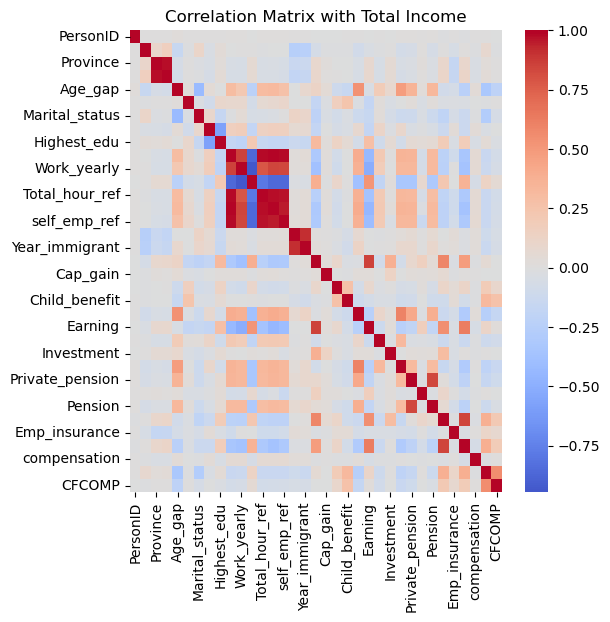

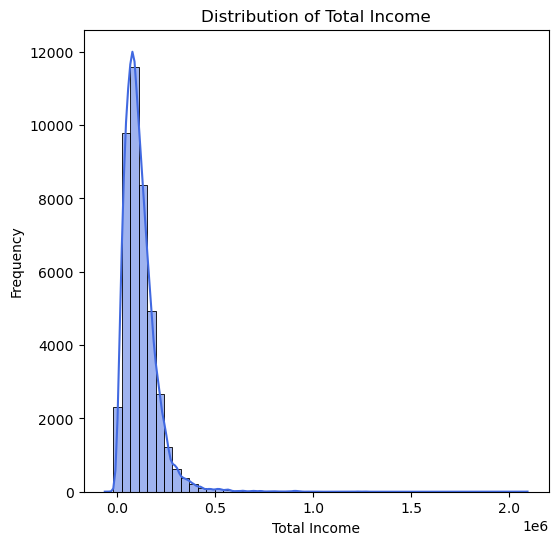

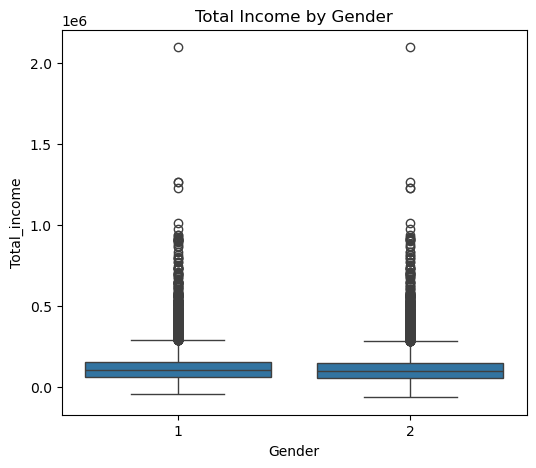

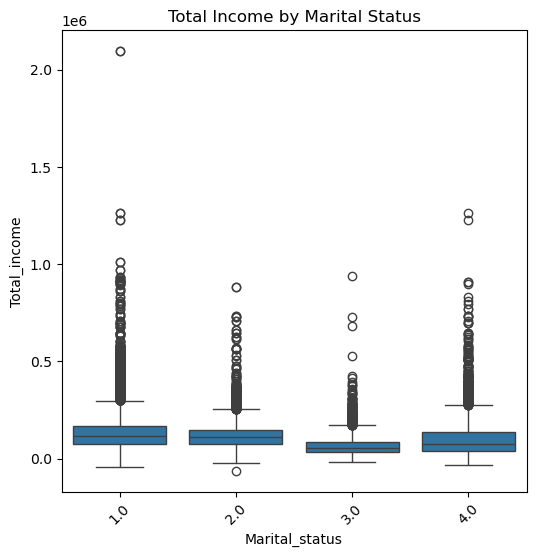

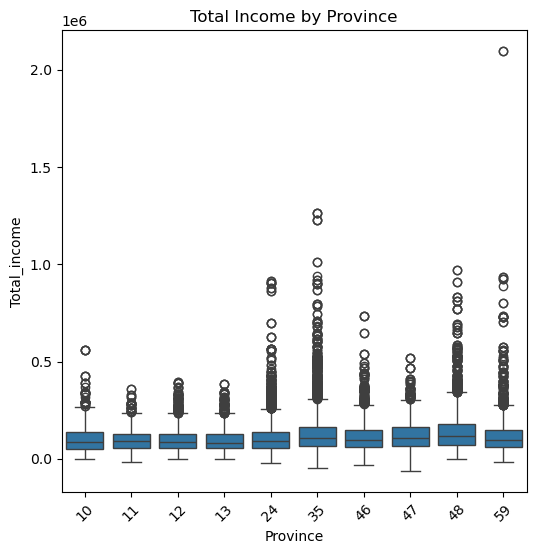

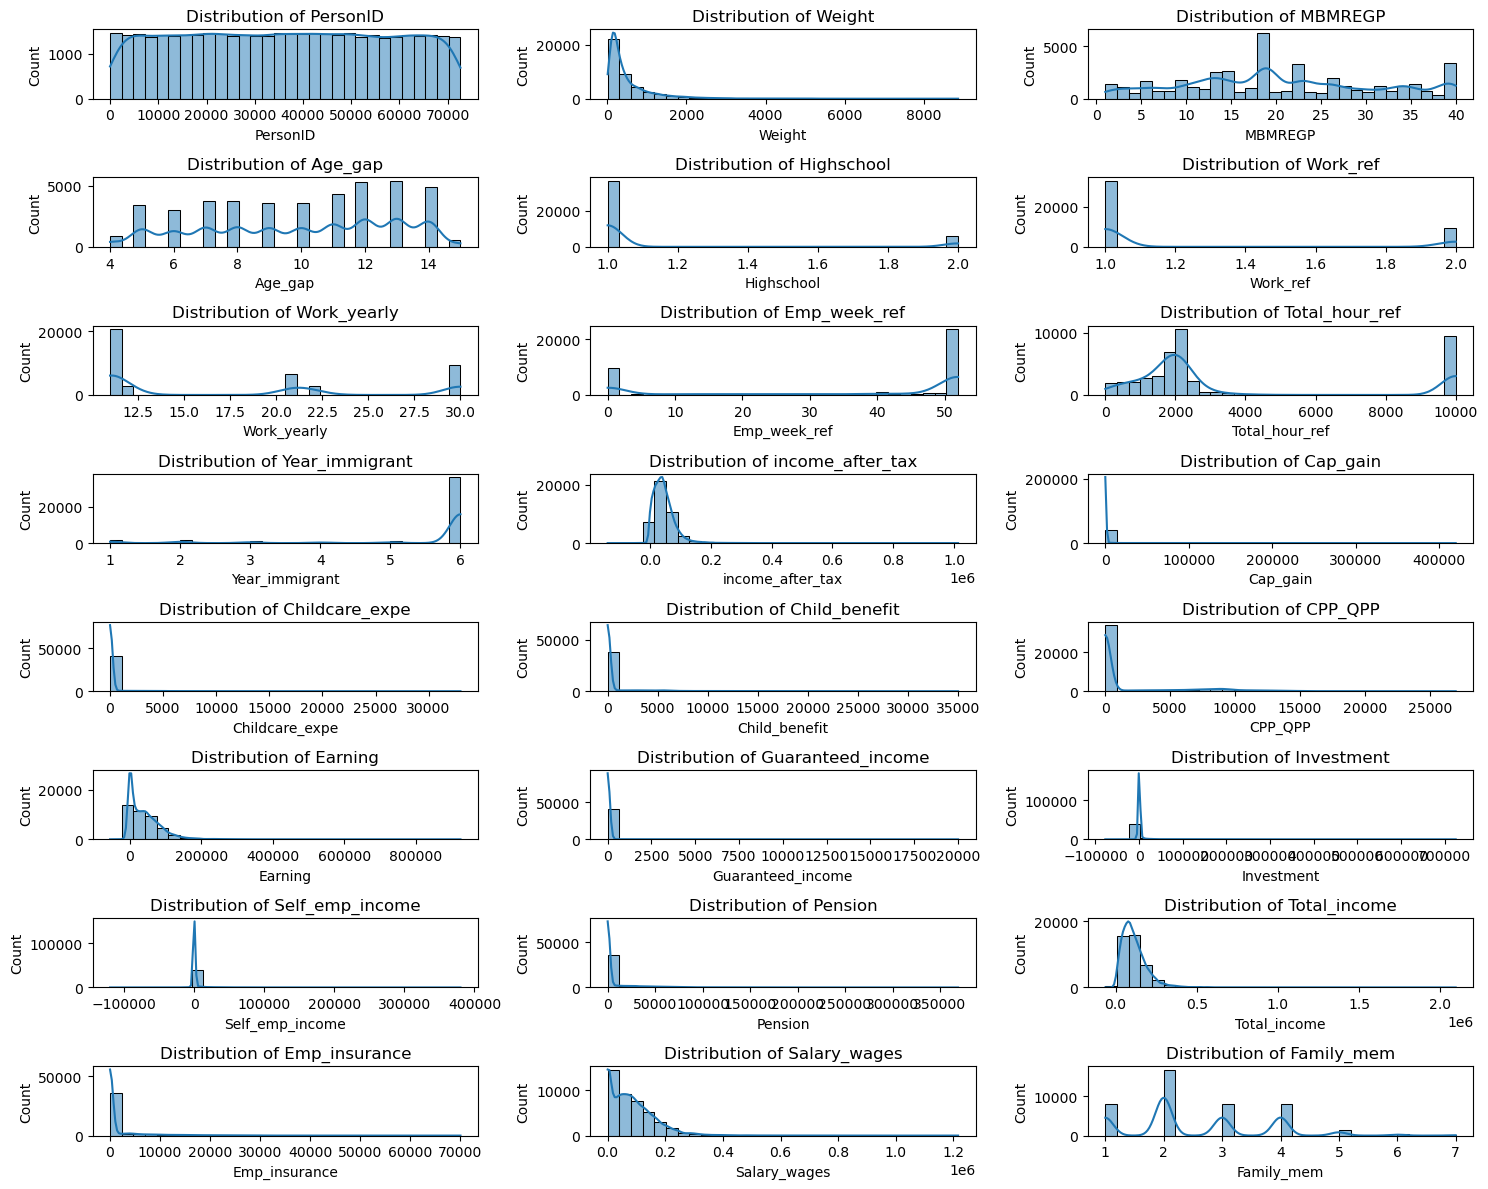

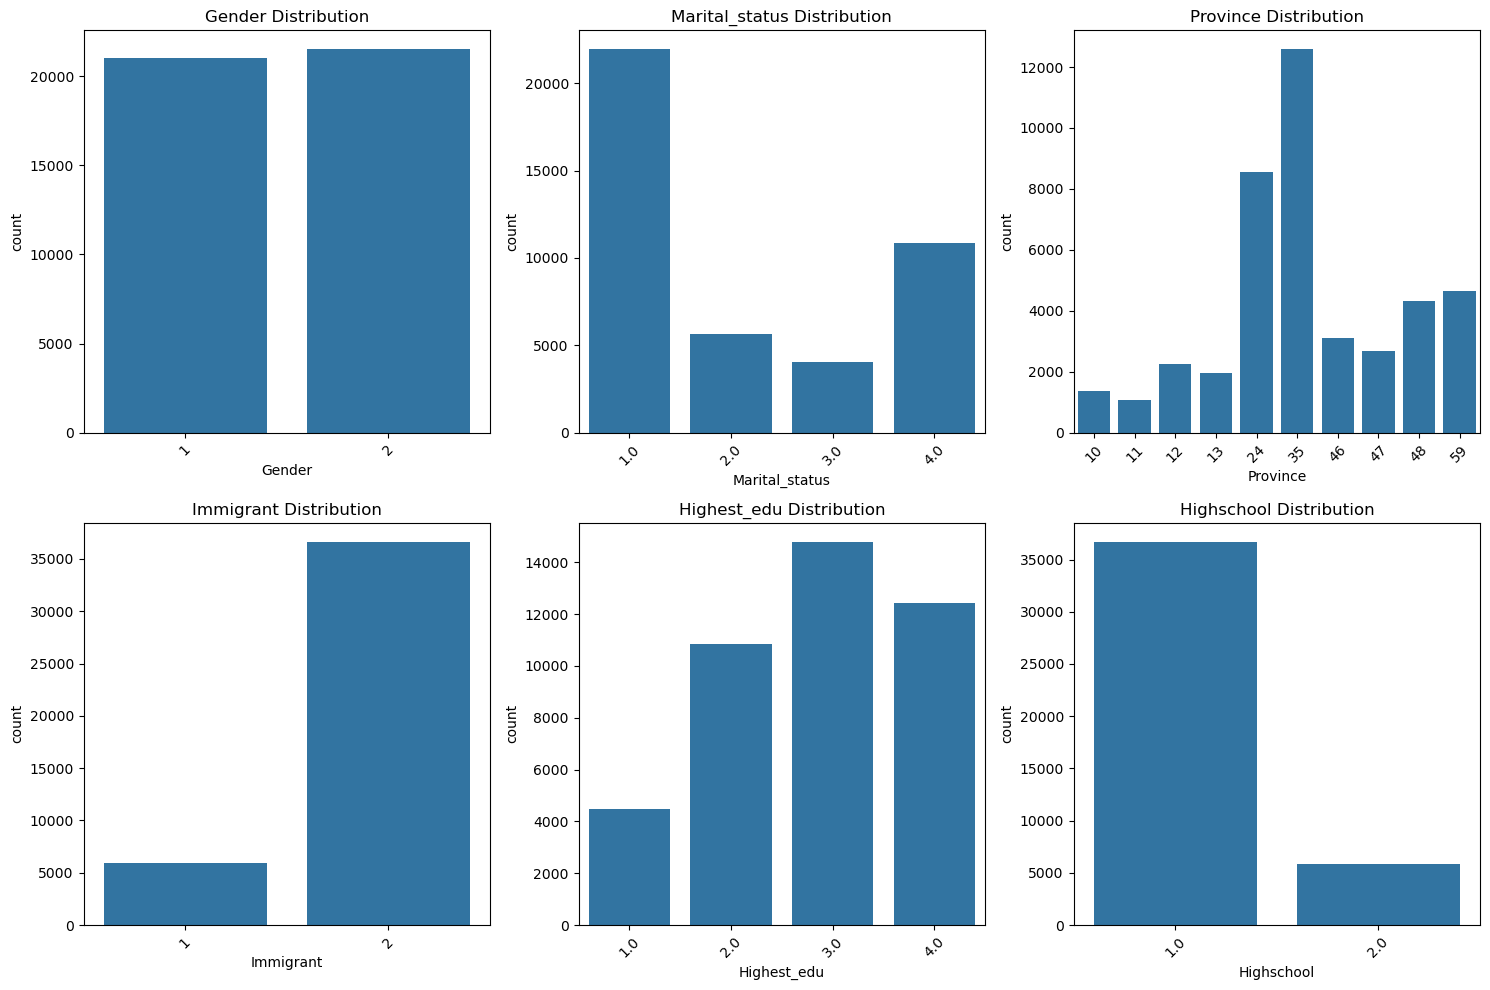

In [144]:
target = 'Total_income'

print(df_income.info())
print(df_income.describe())

missing_values = df_income.isnull().sum().sort_values(ascending=False)
print(missing_values[missing_values > 0])

plt.figure(figsize=(6, 6))
corr = df_income.corr(numeric_only=True)
sns.heatmap(corr, annot=False, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Matrix with Total Income')
plt.show()


plt.figure(figsize=(6, 6))
sns.histplot(df_income[target], bins=50, kde=True, color='royalblue')
plt.title('Distribution of Total Income')
plt.xlabel('Total Income')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(6, 5))
sns.boxplot(x='Gender', y=target, data=df_income)
plt.title('Total Income by Gender')
plt.show()

plt.figure(figsize=(6, 6))
sns.boxplot(x='Marital_status', y=target, data=df_income)
plt.xticks(rotation=45)
plt.title('Total Income by Marital Status')
plt.show()

plt.figure(figsize=(6, 6))
sns.boxplot(x='Province', y=target, data=df_income)
plt.xticks(rotation=45)
plt.title('Total Income by Province')
plt.show()

num_cols = ['PersonID', 'Weight', 'MBMREGP', 'Age_gap', 'Highschool',  'Work_ref',
       'Work_yearly', 'Emp_week_ref', 'Total_hour_ref', 'Year_immigrant', 'income_after_tax',
       'Cap_gain', 'Childcare_expe', 'Child_benefit', 'CPP_QPP', 'Earning',
       'Guaranteed_income', 'Investment',
       'Self_emp_income', 'Pension', 'Total_income',
       'Emp_insurance', 'Salary_wages', 'Family_mem']

# cap_gain, Childcare_expe, Child_benefit, CPP_QPP, Earning, Guaranteed_income, Investment, Self_emp_income

fig, axes = plt.subplots(nrows=8, ncols=3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(df_income[col], ax=axes[i], bins=30, kde=True)
    axes[i].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

cat_features = ['Gender', 'Marital_status', 'Province', 'Immigrant', 'Highest_edu', 'Highschool']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(cat_features):
    sns.countplot(x=col, data=df_income, ax=axes[i])
    axes[i].set_title(f'{col} Distribution')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [145]:
y = df_income["Total_income"]
X = df_income.drop(columns=["Total_income"])

In [146]:
from sklearn.model_selection import train_test_split

X_train_test, X_val, y_train_test, y_val = train_test_split(X, y, test_size=0.2, random_state=26)

X_train, X_test, y_train, y_test = train_test_split(X_train_test, y_train_test, test_size=0.2, random_state=26)

X_train

,PersonID,Weight,Province,MBMREGP,Age_gap,Gender,Marital_status,Highschool,Highest_edu,Work_ref,...,Investment,Old_age_pension,Private_pension,Self_emp_income,Pension,Emp_insurance,Salary_wages,compensation,Family_mem,CFCOMP
36205,36206,243.3982,35,18,12,2,1.0,1.0,4.0,1,...,2300.0,0.0,2000.0,0.0,37100,0,172100,0,3,4
39889,39890,442.2546,35,19,6,1,4.0,1.0,3.0,1,...,0.0,0.0,0.0,0.0,41100,0,107150,0,3,5
60630,60631,108.9101,48,33,14,1,1.0,1.0,4.0,2,...,2300.0,7250.0,24500.0,0.0,63500,0,0,0,2,3
29091,29092,35.0210,46,24,14,1,1.0,2.0,1.0,1,...,1150.0,7500.0,15000.0,0.0,38000,0,48000,0,2,3
69543,69544,671.5520,35,21,13,1,1.0,1.0,4.0,1,...,275.0,0.0,0.0,34000.0,0,0,0,0,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29827,29828,344.6171,12,6,5,2,4.0,1.0,2.0,1,...,0.0,0.0,0.0,0.0,0,0,8800,0,5,4
12283,12284,356.9295,35,20,12,1,1.0,1.0,3.0,1,...,22000.0,0.0,0.0,0.0,0,0,37500,0,2,3
65314,65315,130.3908,47,29,12,2,1.0,1.0,4.0,1,...,375.0,0.0,0.0,0.0,0,2100,132500,0,3,5
62014,62015,857.5506,24,11,12,2,1.0,1.0,3.0,2,...,0.0,0.0,0.0,0.0,0,0,92500,0,2,3


In [147]:
import os 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss

mlflow.set_experiment('LAB2_')

os.makedirs('save_data', exist_ok = True)
y_train_df = pd.DataFrame(y_train)
y_test_df = pd.DataFrame(y_test)
y_val_df = pd.DataFrame(y_val)
X_train.to_parquet('save_data/x_train.parquet')
y_train_df.to_parquet('save_data/y_train.parquet')

mlflow.log_artifact('save_data/x_train.parquet')
mlflow.log_artifact('save_data/y_train.parquet')

X_test.to_parquet('save_data/x_test.parquet')
y_test_df.to_parquet('save_data/y_test.parquet')

mlflow.log_artifact('save_data/x_test.parquet')
mlflow.log_artifact('save_data/y_test.parquet')

X_val.to_parquet('save_data/x_val.parquet')
y_val_df.to_parquet('save_data/y_val.parquet')

mlflow.log_artifact('save_data/x_val.parquet')
mlflow.log_artifact('save_data/y_val.parquet')

mlflow.log_artifacts('save_data/')

2025/03/23 23:38:18 INFO mlflow.tracking.fluent: Experiment with name 'LAB2_' does not exist. Creating a new experiment.


In [148]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import mlflow

mlflow.end_run()

def objective(params):
    with mlflow.start_run():
        regressor_type = params['type']
        del params['type']

        # Choose the appropriate regressor
        if regressor_type == 'dt':
            reg = DecisionTreeRegressor(**params)
        elif regressor_type == 'rf':
            reg = RandomForestRegressor(**params)
        elif regressor_type == 'xgb':
            reg = XGBRegressor(**params, eval_metric='rmse')
        else:
            return 0

        # Train the model
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_test)

        # Calculate regression metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Log metrics
        mlflow.set_tag("Model", regressor_type)
        mlflow.log_params(params)
        mlflow.log_metric("mse", mse)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("r2_score", r2)

        os.makedirs('save_data', exist_ok = True)
        y_train_df = pd.DataFrame(y_train)
        y_test_df = pd.DataFrame(y_test)
        y_val_df = pd.DataFrame(y_val)
        X_train.to_parquet('save_data/x_train.parquet')
        y_train_df.to_parquet('save_data/y_train.parquet')

        mlflow.log_artifact('save_data/x_train.parquet')
        mlflow.log_artifact('save_data/y_train.parquet')

        X_test.to_parquet('save_data/x_test.parquet')
        y_test_df.to_parquet('save_data/y_test.parquet')

        mlflow.log_artifact('save_data/x_test.parquet')
        mlflow.log_artifact('save_data/y_test.parquet')

        X_val.to_parquet('save_data/x_val.parquet')
        y_val_df.to_parquet('save_data/y_val.parquet')

        mlflow.log_artifact('save_data/x_val.parquet')
        mlflow.log_artifact('save_data/y_val.parquet')

        mlflow.log_artifacts('save_data/')

        # Log model
        mlflow.sklearn.log_model(reg, artifact_path='better_models')
        mlflow.end_run()

        # Use RMSE as the loss (since lower is better)
        return {'loss': rmse, 'status': STATUS_OK}

# Hyperparameter search space
search_space = hp.choice('regressor_type', [
    {
        'type': 'dt',
        'criterion': hp.choice('dtree_criterion', ['squared_error', 'friedman_mse']),
        'max_depth': hp.choice('dtree_max_depth', [None, hp.randint('dtree_max_depth_int', 1, 10)]),
        'min_samples_split': hp.randint('dtree_min_samples_split', 2, 10)
    },
    {
        'type': 'rf',
        'n_estimators': hp.randint('rf_n_estimators', 50, 500),
        'max_features': hp.randint('rf_max_features', 2, 9),
        'criterion': hp.choice('rf_criterion', ['squared_error', 'friedman_mse'])
    },
    {
        'type': 'xgb',
        'n_estimators': hp.randint('xgb_n_estimators', 50, 500),
        'max_depth': hp.randint('xgb_max_depth', 3, 10),
        'learning_rate': hp.uniform('xgb_learning_rate', 0.01, 0.3),
        'subsample': hp.uniform('xgb_subsample', 0.5, 1.0),
        'colsample_bytree': hp.uniform('xgb_colsample_bytree', 0.5, 1.0),
        'gamma': hp.uniform('xgb_gamma', 0, 5),
        'reg_alpha': hp.uniform('xgb_reg_alpha', 0, 1),
        'reg_lambda': hp.uniform('xgb_reg_lambda', 0, 1)
    }
])

# Optimization
algo = tpe.suggest
trials = Trials()
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=algo,
    max_evals=32,
    trials=trials
)


  0%|          | 0/32 [00:00<?, ?trial/s, best loss=?]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:38:22 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



  3%|▎         | 1/32 [00:01<00:55,  1.78s/trial, best loss: 32128.461427486684]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:38:30 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



  6%|▋         | 2/32 [00:09<02:47,  5.57s/trial, best loss: 32128.461427486684]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:38:32 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



  9%|▉         | 3/32 [00:11<01:47,  3.69s/trial, best loss: 32128.461427486684]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:38:56 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 12%|█▎        | 4/32 [00:35<05:28, 11.72s/trial, best loss: 27712.98499669769] 

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:38:58 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 16%|█▌        | 5/32 [00:38<03:47,  8.44s/trial, best loss: 27712.98499669769]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:39:00 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 19%|█▉        | 6/32 [00:39<02:40,  6.16s/trial, best loss: 26933.00301174782]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:39:01 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 22%|██▏       | 7/32 [00:41<01:53,  4.53s/trial, best loss: 26933.00301174782]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:39:03 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 25%|██▌       | 8/32 [00:42<01:25,  3.56s/trial, best loss: 26933.00301174782]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:39:04 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 28%|██▊       | 9/32 [00:44<01:07,  2.95s/trial, best loss: 26657.726406708247]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:39:15 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 31%|███▏      | 10/32 [00:54<01:55,  5.24s/trial, best loss: 26657.726406708247]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:39:16 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 34%|███▍      | 11/32 [00:55<01:25,  4.09s/trial, best loss: 26657.726406708247]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:39:18 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 38%|███▊      | 12/32 [00:57<01:08,  3.43s/trial, best loss: 26657.726406708247]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:39:20 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 41%|████      | 13/32 [00:59<00:53,  2.84s/trial, best loss: 26657.726406708247]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:39:21 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 44%|████▍     | 14/32 [01:01<00:44,  2.49s/trial, best loss: 25662.975180411657]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:39:29 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 47%|████▋     | 15/32 [01:08<01:06,  3.92s/trial, best loss: 25662.975180411657]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:39:32 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 50%|█████     | 16/32 [01:11<00:58,  3.68s/trial, best loss: 25662.975180411657]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:39:33 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 53%|█████▎    | 17/32 [01:13<00:45,  3.06s/trial, best loss: 25662.975180411657]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:39:35 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 56%|█████▋    | 18/32 [01:14<00:36,  2.60s/trial, best loss: 25662.975180411657]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:39:36 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 59%|█████▉    | 19/32 [01:16<00:29,  2.26s/trial, best loss: 25662.975180411657]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:39:38 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 62%|██████▎   | 20/32 [01:17<00:25,  2.12s/trial, best loss: 25662.975180411657]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:39:40 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 66%|██████▌   | 21/32 [01:19<00:20,  1.89s/trial, best loss: 25662.975180411657]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:39:42 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 69%|██████▉   | 22/32 [01:21<00:21,  2.13s/trial, best loss: 25258.106701948585]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:39:44 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 72%|███████▏  | 23/32 [01:23<00:17,  1.96s/trial, best loss: 25258.106701948585]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:39:45 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 75%|███████▌  | 24/32 [01:24<00:14,  1.78s/trial, best loss: 25258.106701948585]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:39:47 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 78%|███████▊  | 25/32 [01:26<00:12,  1.86s/trial, best loss: 25258.106701948585]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:39:48 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 81%|████████▏ | 26/32 [01:28<00:10,  1.68s/trial, best loss: 25258.106701948585]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:39:51 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 84%|████████▍ | 27/32 [01:30<00:09,  1.98s/trial, best loss: 25258.106701948585]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:39:54 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 88%|████████▊ | 28/32 [01:33<00:09,  2.31s/trial, best loss: 25258.106701948585]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:40:15 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 91%|█████████ | 29/32 [01:54<00:23,  7.97s/trial, best loss: 25258.106701948585]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:40:17 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 94%|█████████▍| 30/32 [01:56<00:12,  6.08s/trial, best loss: 25258.106701948585]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:40:18 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 97%|█████████▋| 31/32 [01:58<00:04,  4.68s/trial, best loss: 25258.106701948585]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:40:50 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



100%|██████████| 32/32 [02:29<00:00,  4.69s/trial, best loss: 25258.106701948585]


## Drop features

              Feature  Importance
30       Salary_wages    0.503915
33             CFCOMP    0.060841
17   income_after_tax    0.058236
28            Pension    0.058235
24         Investment    0.049138
27    Self_emp_income    0.023439
32         Family_mem    0.017186
14       self_emp_ref    0.016725
13       paid_emp_ref    0.016083
6      Marital_status    0.012595
3             MBMREGP    0.012257
5              Gender    0.011441
20      Child_benefit    0.010319
18           Cap_gain    0.009522
31       compensation    0.009488
4             Age_gap    0.009384
29      Emp_insurance    0.009347
21            CPP_QPP    0.008587
1              Weight    0.008410
9            Work_ref    0.008164
11       Emp_week_ref    0.008099
19     Childcare_expe    0.007927
10        Work_yearly    0.007764
2            Province    0.007652
12     Total_hour_ref    0.007112
0            PersonID    0.007098
22            Earning    0.007047
16     Year_immigrant    0.007013
26    Private_

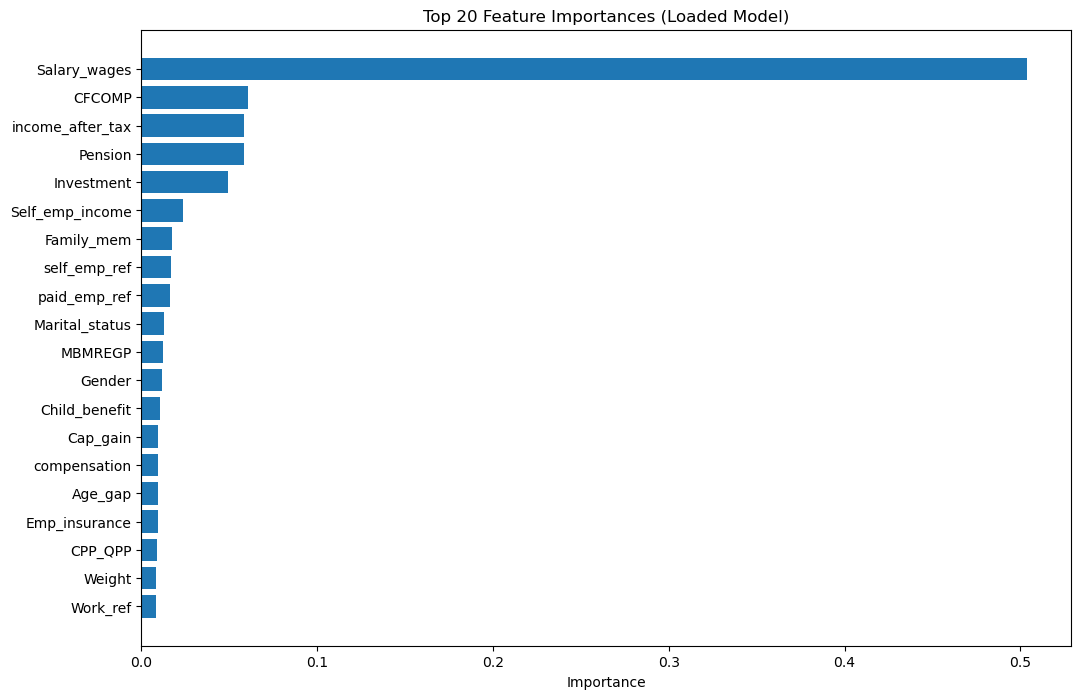

In [150]:
import mlflow
import mlflow.sklearn

logged_model = 'runs:/ddef6ffc6f464585922da8a7200cd11e/better_models'

rf = mlflow.sklearn.load_model(logged_model)

feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances)

# Plot the top 20 most important features
plt.figure(figsize=(12, 8))
plt.barh(feature_importances['Feature'][:20], feature_importances['Importance'][:20])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances (Loaded Model)')
plt.show()


In [153]:
to_remove = feature_importances[feature_importances['Importance'] < 0.009]['Feature'].tolist()
    
print(f"Features to remove (Importance < {threshold}):")
for feature in to_remove:
    print(f"- {feature}")


Features to remove (Importance < 10000000.0):
- CPP_QPP
- Weight
- Work_ref
- Emp_week_ref
- Childcare_expe
- Work_yearly
- Province
- Total_hour_ref
- PersonID
- Earning
- Year_immigrant
- Private_pension
- Immigrant
- Highest_edu
- Old_age_pension
- Highschool
- Guaranteed_income


In [154]:
X_train_reduced = X_train.drop(columns=to_remove, errors='ignore')
X_test_reduced = X_test.drop(columns=to_remove, errors='ignore')

X_val_reduced = X_val.drop(columns=to_remove, errors='ignore')

In [155]:
mlflow.set_experiment('LAB2_Selected')

def objective(params):
    with mlflow.start_run():
        regressor_type = params['type']
        del params['type']

        # Choose the appropriate regressor
        if regressor_type == 'dt':
            reg = DecisionTreeRegressor(**params)
        elif regressor_type == 'rf':
            reg = RandomForestRegressor(**params)
        elif regressor_type == 'xgb':
            reg = XGBRegressor(**params, eval_metric='rmse')
        else:
            return 0

        # Train the model
        reg.fit(X_train_reduced, y_train)
        y_pred = reg.predict(X_test_reduced)

        # Calculate regression metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Log metrics
        mlflow.set_tag("Model", regressor_type)
        mlflow.log_params(params)
        mlflow.log_metric("mse", mse)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("r2_score", r2)

        os.makedirs('save_data', exist_ok = True)
        y_train_df = pd.DataFrame(y_train)
        y_test_df = pd.DataFrame(y_test)
        y_val_df = pd.DataFrame(y_val)
        X_train_reduced.to_parquet('save_data/x_train.parquet')
        y_train_df.to_parquet('save_data/y_train.parquet')

        mlflow.log_artifact('save_data/x_train.parquet')
        mlflow.log_artifact('save_data/y_train.parquet')

        X_test_reduced.to_parquet('save_data/x_test.parquet')
        y_test_df.to_parquet('save_data/y_test.parquet')

        mlflow.log_artifact('save_data/x_test.parquet')
        mlflow.log_artifact('save_data/y_test.parquet')

        X_val_reduced.to_parquet('save_data/x_val.parquet')
        y_val_df.to_parquet('save_data/y_val.parquet')

        mlflow.log_artifact('save_data/x_val.parquet')
        mlflow.log_artifact('save_data/y_val.parquet')

        mlflow.log_artifacts('save_data/')

        # Log model
        mlflow.sklearn.log_model(reg, artifact_path='better_models')
        mlflow.end_run()

        # Use RMSE as the loss (since lower is better)
        return {'loss': rmse, 'status': STATUS_OK}

# Hyperparameter search space
search_space = hp.choice('regressor_type', [
    {
        'type': 'dt',
        'criterion': hp.choice('dtree_criterion', ['squared_error', 'friedman_mse']),
        'max_depth': hp.choice('dtree_max_depth', [None, hp.randint('dtree_max_depth_int', 1, 10)]),
        'min_samples_split': hp.randint('dtree_min_samples_split', 2, 10)
    },
    {
        'type': 'rf',
        'n_estimators': hp.randint('rf_n_estimators', 50, 500),
        'max_features': hp.randint('rf_max_features', 2, 9),
        'criterion': hp.choice('rf_criterion', ['squared_error', 'friedman_mse'])
    },
    {
        'type': 'xgb',
        'n_estimators': hp.randint('xgb_n_estimators', 50, 500),
        'max_depth': hp.randint('xgb_max_depth', 3, 10),
        'learning_rate': hp.uniform('xgb_learning_rate', 0.01, 0.3),
        'subsample': hp.uniform('xgb_subsample', 0.5, 1.0),
        'colsample_bytree': hp.uniform('xgb_colsample_bytree', 0.5, 1.0),
        'gamma': hp.uniform('xgb_gamma', 0, 5),
        'reg_alpha': hp.uniform('xgb_reg_alpha', 0, 1),
        'reg_lambda': hp.uniform('xgb_reg_lambda', 0, 1)
    }
])

# Optimization
algo = tpe.suggest
trials = Trials()
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=algo,
    max_evals=32,
    trials=trials
)
best_result

2025/03/23 23:44:02 INFO mlflow.tracking.fluent: Experiment with name 'LAB2_Selected' does not exist. Creating a new experiment.


  0%|          | 0/32 [00:00<?, ?trial/s, best loss=?]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:44:08 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



  3%|▎         | 1/32 [00:05<02:51,  5.54s/trial, best loss: 27834.238977566838]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:44:09 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



  6%|▋         | 2/32 [00:07<01:37,  3.26s/trial, best loss: 27805.51103892958] 

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:44:20 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



  9%|▉         | 3/32 [00:17<03:11,  6.61s/trial, best loss: 26319.680646132518]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:44:21 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 12%|█▎        | 4/32 [00:18<02:04,  4.46s/trial, best loss: 26319.680646132518]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:44:23 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 16%|█▌        | 5/32 [00:20<01:30,  3.35s/trial, best loss: 26319.680646132518]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:44:25 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 19%|█▉        | 6/32 [00:22<01:15,  2.91s/trial, best loss: 26319.680646132518]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:44:46 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 22%|██▏       | 7/32 [00:43<03:42,  8.90s/trial, best loss: 24958.036106626383]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:44:47 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 25%|██▌       | 8/32 [00:44<02:35,  6.47s/trial, best loss: 24958.036106626383]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:44:48 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 28%|██▊       | 9/32 [00:46<01:51,  4.84s/trial, best loss: 24958.036106626383]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:45:09 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 31%|███▏      | 10/32 [01:06<03:33,  9.69s/trial, best loss: 24950.18919272136]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:45:10 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 34%|███▍      | 11/32 [01:07<02:29,  7.10s/trial, best loss: 24950.18919272136]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:45:11 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 38%|███▊      | 12/32 [01:09<01:45,  5.29s/trial, best loss: 24950.18919272136]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:45:12 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 41%|████      | 13/32 [01:10<01:16,  4.05s/trial, best loss: 24950.18919272136]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:45:24 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 44%|████▍     | 14/32 [01:22<01:56,  6.45s/trial, best loss: 24950.18919272136]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:45:49 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 47%|████▋     | 15/32 [01:47<03:23, 11.96s/trial, best loss: 24950.18919272136]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:45:59 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 50%|█████     | 16/32 [01:57<03:03, 11.45s/trial, best loss: 24950.18919272136]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:46:01 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 53%|█████▎    | 17/32 [01:58<02:05,  8.36s/trial, best loss: 24950.18919272136]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:46:02 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 56%|█████▋    | 18/32 [02:00<01:28,  6.35s/trial, best loss: 24950.18919272136]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:46:04 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 59%|█████▉    | 19/32 [02:01<01:04,  4.97s/trial, best loss: 24950.18919272136]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:46:05 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 62%|██████▎   | 20/32 [02:03<00:46,  3.86s/trial, best loss: 24950.18919272136]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:46:28 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 66%|██████▌   | 21/32 [02:25<01:43,  9.38s/trial, best loss: 24950.18919272136]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:46:47 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 69%|██████▉   | 22/32 [02:45<02:04, 12.50s/trial, best loss: 24828.865265708348]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:47:02 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 72%|███████▏  | 23/32 [02:59<01:57, 13.09s/trial, best loss: 24828.865265708348]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:47:32 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 75%|███████▌  | 24/32 [03:30<02:26, 18.36s/trial, best loss: 24804.255962276653]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:47:56 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 78%|███████▊  | 25/32 [03:54<02:20, 20.07s/trial, best loss: 24804.255962276653]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:48:23 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 81%|████████▏ | 26/32 [04:20<02:11, 21.96s/trial, best loss: 24801.68523710666] 

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:48:27 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 84%|████████▍ | 27/32 [04:24<01:22, 16.49s/trial, best loss: 24801.68523710666]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:48:39 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 88%|████████▊ | 28/32 [04:37<01:01, 15.33s/trial, best loss: 24801.68523710666]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:49:08 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 91%|█████████ | 29/32 [05:06<00:58, 19.52s/trial, best loss: 24801.68523710666]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:49:21 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 94%|█████████▍| 30/32 [05:18<00:34, 17.44s/trial, best loss: 24801.68523710666]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:49:34 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 97%|█████████▋| 31/32 [05:32<00:16, 16.17s/trial, best loss: 24801.68523710666]

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

2025/03/23 23:49:42 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



100%|██████████| 32/32 [05:40<00:00, 10.63s/trial, best loss: 24801.68523710666]


{'regressor_type': 1,
 'rf_criterion': 1,
 'rf_max_features': 8,
 'rf_n_estimators': 381}

In [156]:
os.makedirs('save_data', exist_ok = True)
y_train_df = pd.DataFrame(y_train)
y_test_df = pd.DataFrame(y_test)
y_val_df = pd.DataFrame(y_val)
X_train_reduced.to_parquet('save_data/x_train.parquet')
y_train_df.to_parquet('save_data/y_train.parquet')

mlflow.log_artifact('save_data/x_train.parquet')
mlflow.log_artifact('save_data/y_train.parquet')

X_test_reduced.to_parquet('save_data/x_test.parquet')
y_test_df.to_parquet('save_data/y_test.parquet')

mlflow.log_artifact('save_data/x_test.parquet')
mlflow.log_artifact('save_data/y_test.parquet')

X_val_reduced.to_parquet('save_data/x_val.parquet')
y_val_df.to_parquet('save_data/y_val.parquet')

mlflow.log_artifact('save_data/x_val.parquet')
mlflow.log_artifact('save_data/y_val.parquet')

mlflow.log_artifacts('save_data/')

In [157]:
mlflow.end_run()

In [158]:
logged_model = 'runs:/d1477f08cacc44aab8d168c6024626b0/better_models' #replace with one of your models

rf = mlflow.sklearn.load_model(logged_model)

y_pred = rf.predict(X_val_reduced)

# Calculate regression metrics
mse = mean_squared_error(y_val, y_pred)
rmse = mean_squared_error(y_val, y_pred, squared=False)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R^2: {r2}")

mlflow.log_metric("val_mse", mse)
mlflow.log_metric("val_rmse", rmse)
mlflow.log_metric("val_mae", mae)
mlflow.log_metric("val_r2_score", r2)

os.makedirs('save_data', exist_ok = True)
y_train_df = pd.DataFrame(y_train)
y_test_df = pd.DataFrame(y_test)
y_val_df = pd.DataFrame(y_val)
X_train_reduced.to_parquet('save_data/x_train.parquet')
y_train_df.to_parquet('save_data/y_train.parquet')

mlflow.log_artifact('save_data/x_train.parquet')
mlflow.log_artifact('save_data/y_train.parquet')

X_test_reduced.to_parquet('save_data/x_test.parquet')
y_test_df.to_parquet('save_data/y_test.parquet')

mlflow.log_artifact('save_data/x_test.parquet')
mlflow.log_artifact('save_data/y_test.parquet')

X_val_reduced.to_parquet('save_data/x_val.parquet')
y_val_df.to_parquet('save_data/y_val.parquet')

mlflow.log_artifact('save_data/x_val.parquet')
mlflow.log_artifact('save_data/y_val.parquet')

mlflow.log_artifacts('save_data/')


MSE: 587055965.200489
RMSE: 24229.23781715985
MAE: 10755.797516602312
R^2: 0.9207171695232038


/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [159]:
runid = 'd1477f08cacc44aab8d168c6024626b0'
mod_path = f'runs:/{runid}/artifacts/better_models'
mlflow.register_model(model_uri = mod_path, name = 'best_model_income')

os.makedirs('save_data', exist_ok = True)
y_train_df = pd.DataFrame(y_train)
y_test_df = pd.DataFrame(y_test)
y_val_df = pd.DataFrame(y_val)
X_train_reduced.to_parquet('save_data/x_train.parquet')
y_train_df.to_parquet('save_data/y_train.parquet')

mlflow.log_artifact('save_data/x_train.parquet')
mlflow.log_artifact('save_data/y_train.parquet')

X_test_reduced.to_parquet('save_data/x_test.parquet')
y_test_df.to_parquet('save_data/y_test.parquet')

mlflow.log_artifact('save_data/x_test.parquet')
mlflow.log_artifact('save_data/y_test.parquet')

X_val_reduced.to_parquet('save_data/x_val.parquet')
y_val_df.to_parquet('save_data/y_val.parquet')

mlflow.log_artifact('save_data/x_val.parquet')
mlflow.log_artifact('save_data/y_val.parquet')

mlflow.log_artifacts('save_data/')

Registered model 'best_model_income' already exists. Creating a new version of this model...
Created version '3' of model 'best_model_income'.


In [160]:
mlflow.end_run()